# LSTM Emulation of CWatM

In [4]:
from typing import List, Optional, Any, Dict, Tuple, Union
from pathlib import Path
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import pandas as pd

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from scripts.read_nh_results import (read_multi_experiment_results, calculate_member_errors)
from neuralhydrology.utils.config import Config
import geopandas as gpd 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from neuralhydrology.nh_run import start_run, finetune, eval_run

# Load Data

In [130]:
data_dir = Path("/datadrive/data")
# run_dir = Path("/datadrive/data/runs/cwatm_azure_no_static_2107_085503")
run_dir = Path("/datadrive/data/runs/cwatm_azure_with_static_1990_2000_2107_090332")
run_dir = Path("/datadrive/data/runs/cwatm_new_basins_0508_125737")
run_dir = Path("/datadrive/data/runs/cwatm_new_basins_CAMELSGBDataloader_1808_104714/")

# load config
cfg = Config(run_dir / "config.yml")
cfg.run_dir = run_dir

In [131]:
EPOCH = 30
res_fp = get_test_filepath(run_dir, epoch=EPOCH)
preds = get_all_station_ds(res_fp)
preds["station_id"] = preds["station_id"].astype(int)

100%|██████████| 864/864 [00:00<00:00, 2078.70it/s]


In [132]:
if not (run_dir / "errors.nc").exists():
    errors = calculate_all_error_metrics(
        preds, basin_coord="station_id", obs_var="discharge_obs", sim_var="discharge_sim", time_coord="date"
    )
    errors.to_netcdf(run_dir / "errors.nc")
else:
    print("Already run errors!")
    errors = xr.open_dataset(run_dir / "errors.nc")
    
errors["station_id"] = errors["station_id"].astype(int)
preds = preds.sel(station_id=errors.station_id)
preds = preds.rename({"date": "time"})

Already run errors!


In [134]:
st_data_dir = Path("/home/tommy/spatio_temporal/data")
if cfg.dataset == "pixel":
    static = xr.open_dataset(cfg.static_nc_file).rename({"basin": "station_id"})
    dynamic = xr.open_dataset(cfg.dynamic_nc_file).rename({"basin": "station_id"})
else:
    static = xr.open_dataset(data_dir / "cwatm_static.nc").rename({"basin": "station_id"})
    dynamic = xr.open_dataset(data_dir / "202108171219_cwatm_ORIG_GRID.nc").rename({"basin": "station_id"})
    

shp_dir = data_dir / "CWATM/shapefile_ALL/"
shp = gpd.read_file(list(shp_dir.glob("*.shp"))[0])
shp.head()

,value,geometry
0,0.0,"POLYGON ((-3.32080 59.13348, -3.28650 59.13683..."
1,1.0,"POLYGON ((-3.31399 59.11586, -3.29685 59.11753..."
2,2.0,"POLYGON ((-3.13687 58.97768, -3.10270 58.98098..."
3,3.0,"POLYGON ((-3.39633 58.91574, -3.37929 58.91743..."
4,4.0,"POLYGON ((-6.32120 58.48228, -6.30450 58.48432..."


# Load model

In [135]:
# load trained model
model = get_model(cfg).to(cfg.device)
_load_weights(model, cfg, epoch=EPOCH)
model

Using the model weights from /datadrive/data/runs/cwatm_new_basins_CAMELSGBDataloader_1808_104714/model_epoch030.pt


CudaLSTM(
  (embedding_net): InputLayer(
    (statics_embedding): Identity()
    (dynamics_embedding): Identity()
  )
  (lstm): LSTM(5, 64)
  (dropout): Dropout(p=0.4, inplace=False)
  (head): Regression(
    (net): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

## check scaler for normalisation

In [136]:
import pickle 


scaler = pickle.load((run_dir / "train_data/train_data_scaler.p").open("rb"))
normed_static = (static[scaler["attribute_stds"].index] - scaler["attribute_means"]) * scaler["attribute_stds"]

## How different are the 

In [137]:
normed_static

<xarray.Dataset>
Dimensions:             (station_id: 864)
Coordinates:
  * station_id          (station_id) int64 0 1 2 3 4 5 ... 859 860 861 862 863
Data variables:
    Precipitation_mean  (station_id) float32 1.383e-07 1.409e-07 ... -2.527e-07
    Tavg_mean           (station_id) float32 -1.443 -1.227 -1.452 ... 2.199 2.34
    area                (station_id) float64 -2.851e+17 ... -2.557e+17

# Get training/test dataset

In [138]:
# ds = xr.open_dataset("/home/tommy/spatio_temporal/data/ALL_dynamic_ds.nc")
ds = xr.open_dataset(data_dir / "cwatm.nc")[["Tavg", "Precipitation", "discharge"]]

def read_basin_list(txt_path: Path) -> pd.DataFrame:
    return pd.read_csv(txt_path, header=None).rename({0: "station_id"}, axis=1)


train_sids = read_basin_list(cfg.train_basin_file)
test_sids = read_basin_list(cfg.test_basin_file)
train_ds = ds.sel(time=slice(cfg.train_start_date, cfg.train_end_date), station_id=np.isin(ds.station_id, train_sids.station_id))
test_ds = ds.sel(time=slice(cfg.test_start_date, cfg.test_end_date), station_id=np.isin(ds.station_id, test_sids.station_id))

In [139]:
print((cfg.train_start_date, cfg.train_end_date))
print((cfg.test_start_date, cfg.test_end_date))

(Timestamp('1990-01-01 00:00:00'), Timestamp('2000-12-31 00:00:00'))
(Timestamp('2001-01-01 00:00:00'), Timestamp('2010-12-31 00:00:00'))


In [140]:
# test_ds.drop(["spatial_ref", "x", "y"])

### get camels

In [141]:
camels = xr.open_dataset("/home/tommy/spatio_temporal/data/ALL_dynamic_ds.nc")
camels = camels.sel(station_id=ds.station_id, time=ds.time)

# Check the Performance of model

In [142]:
# preds = xr.open_dataset(Path(".").home() / "results.nc")

# preds

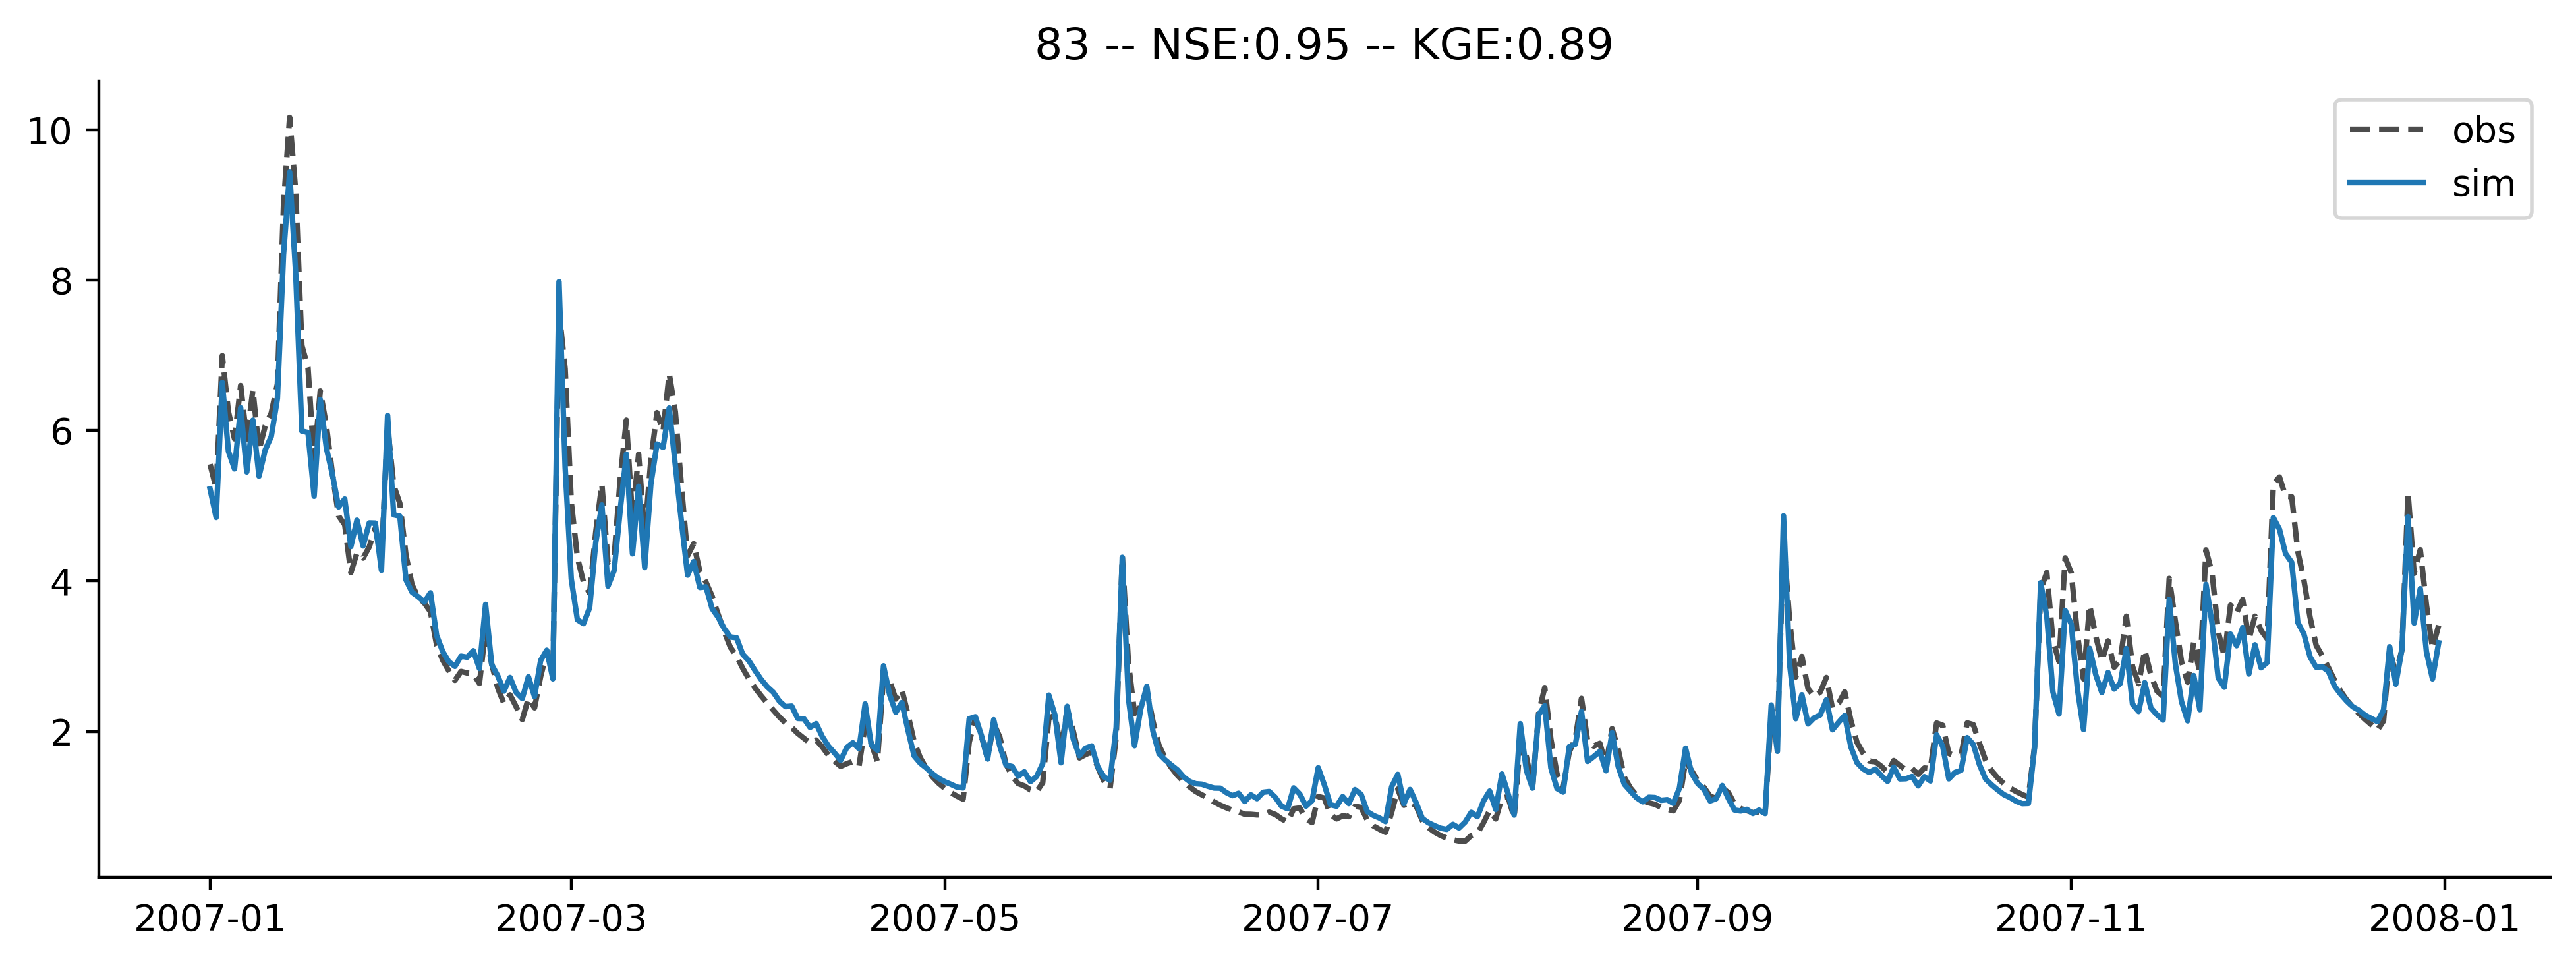

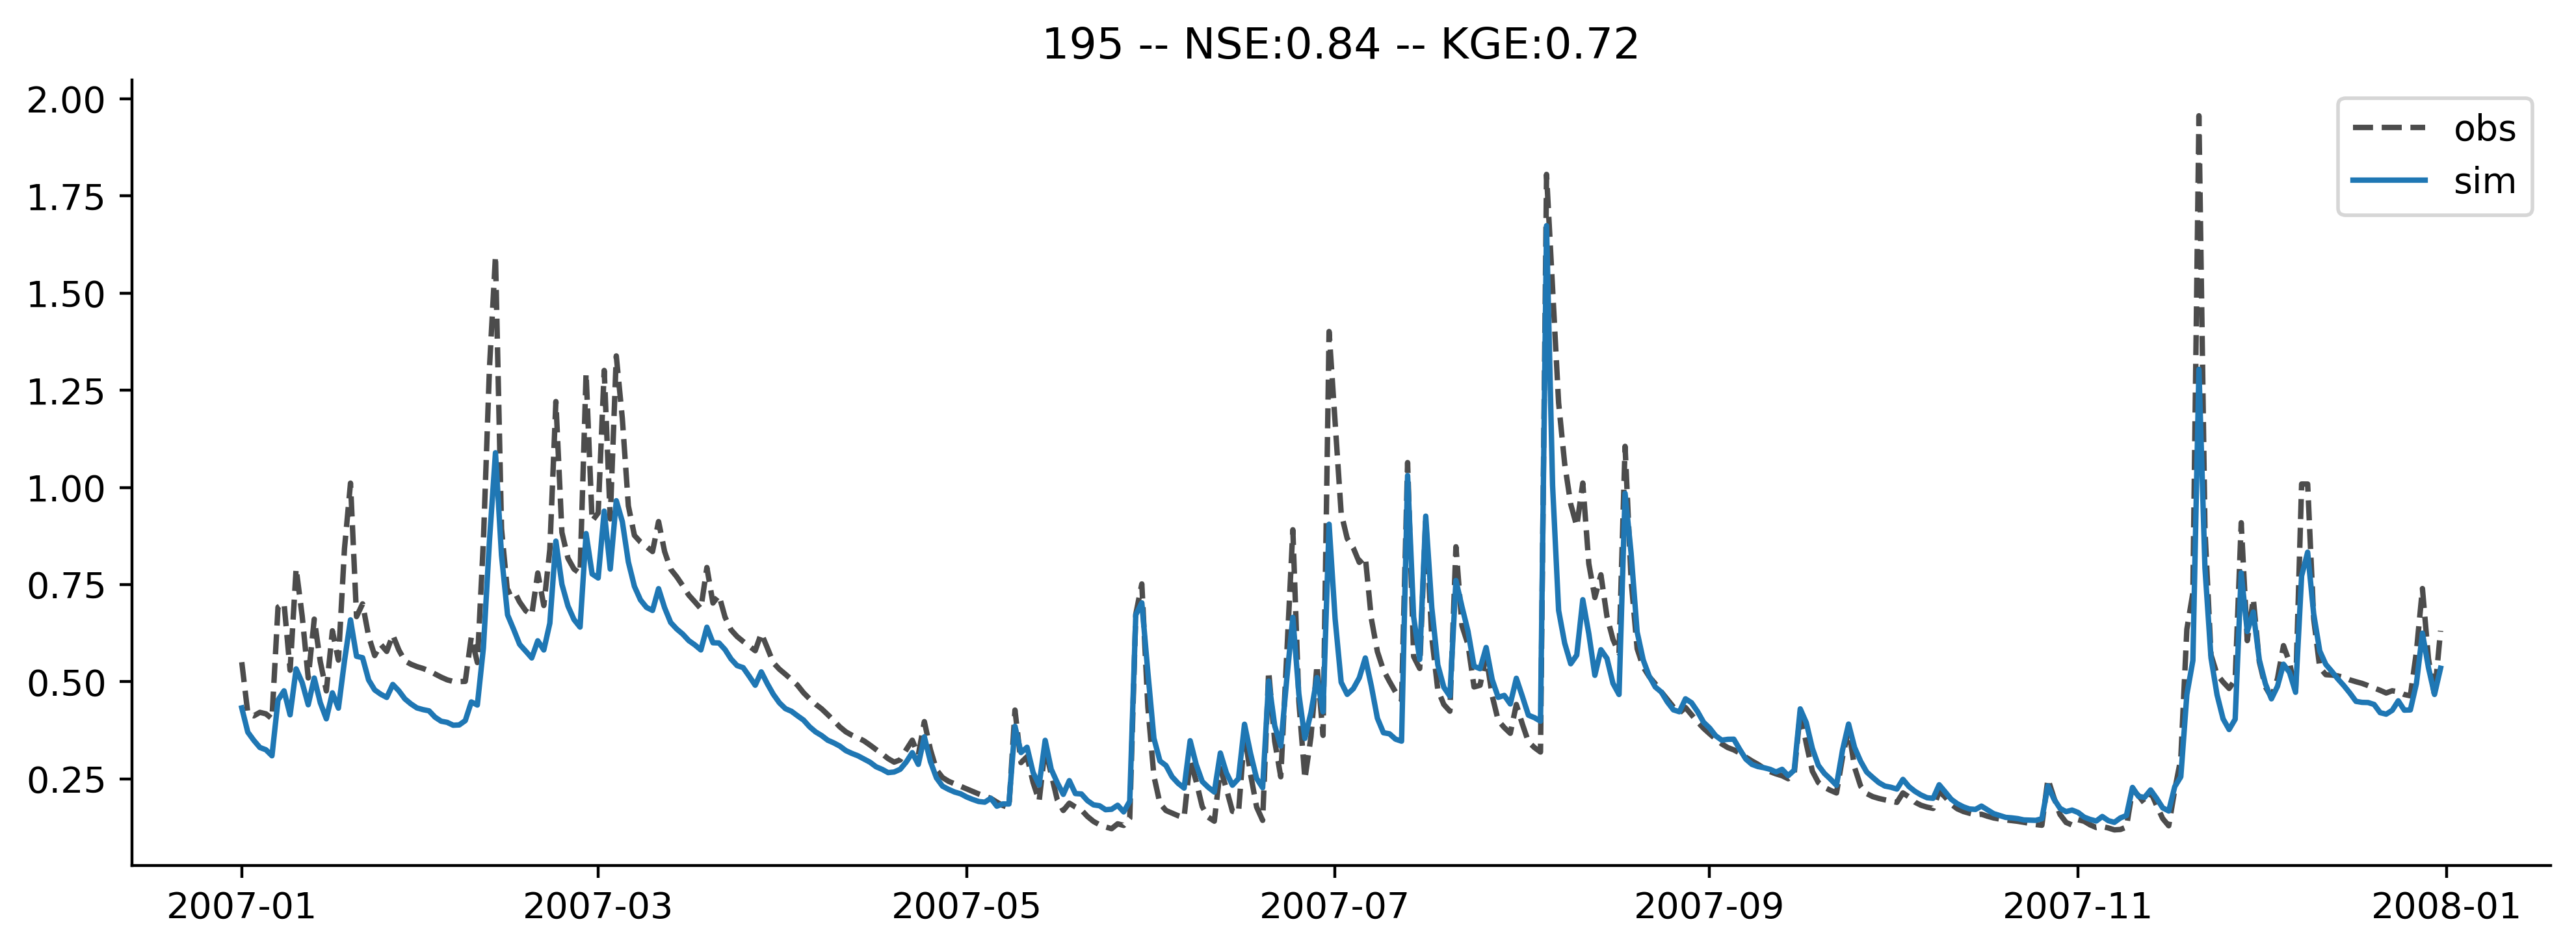

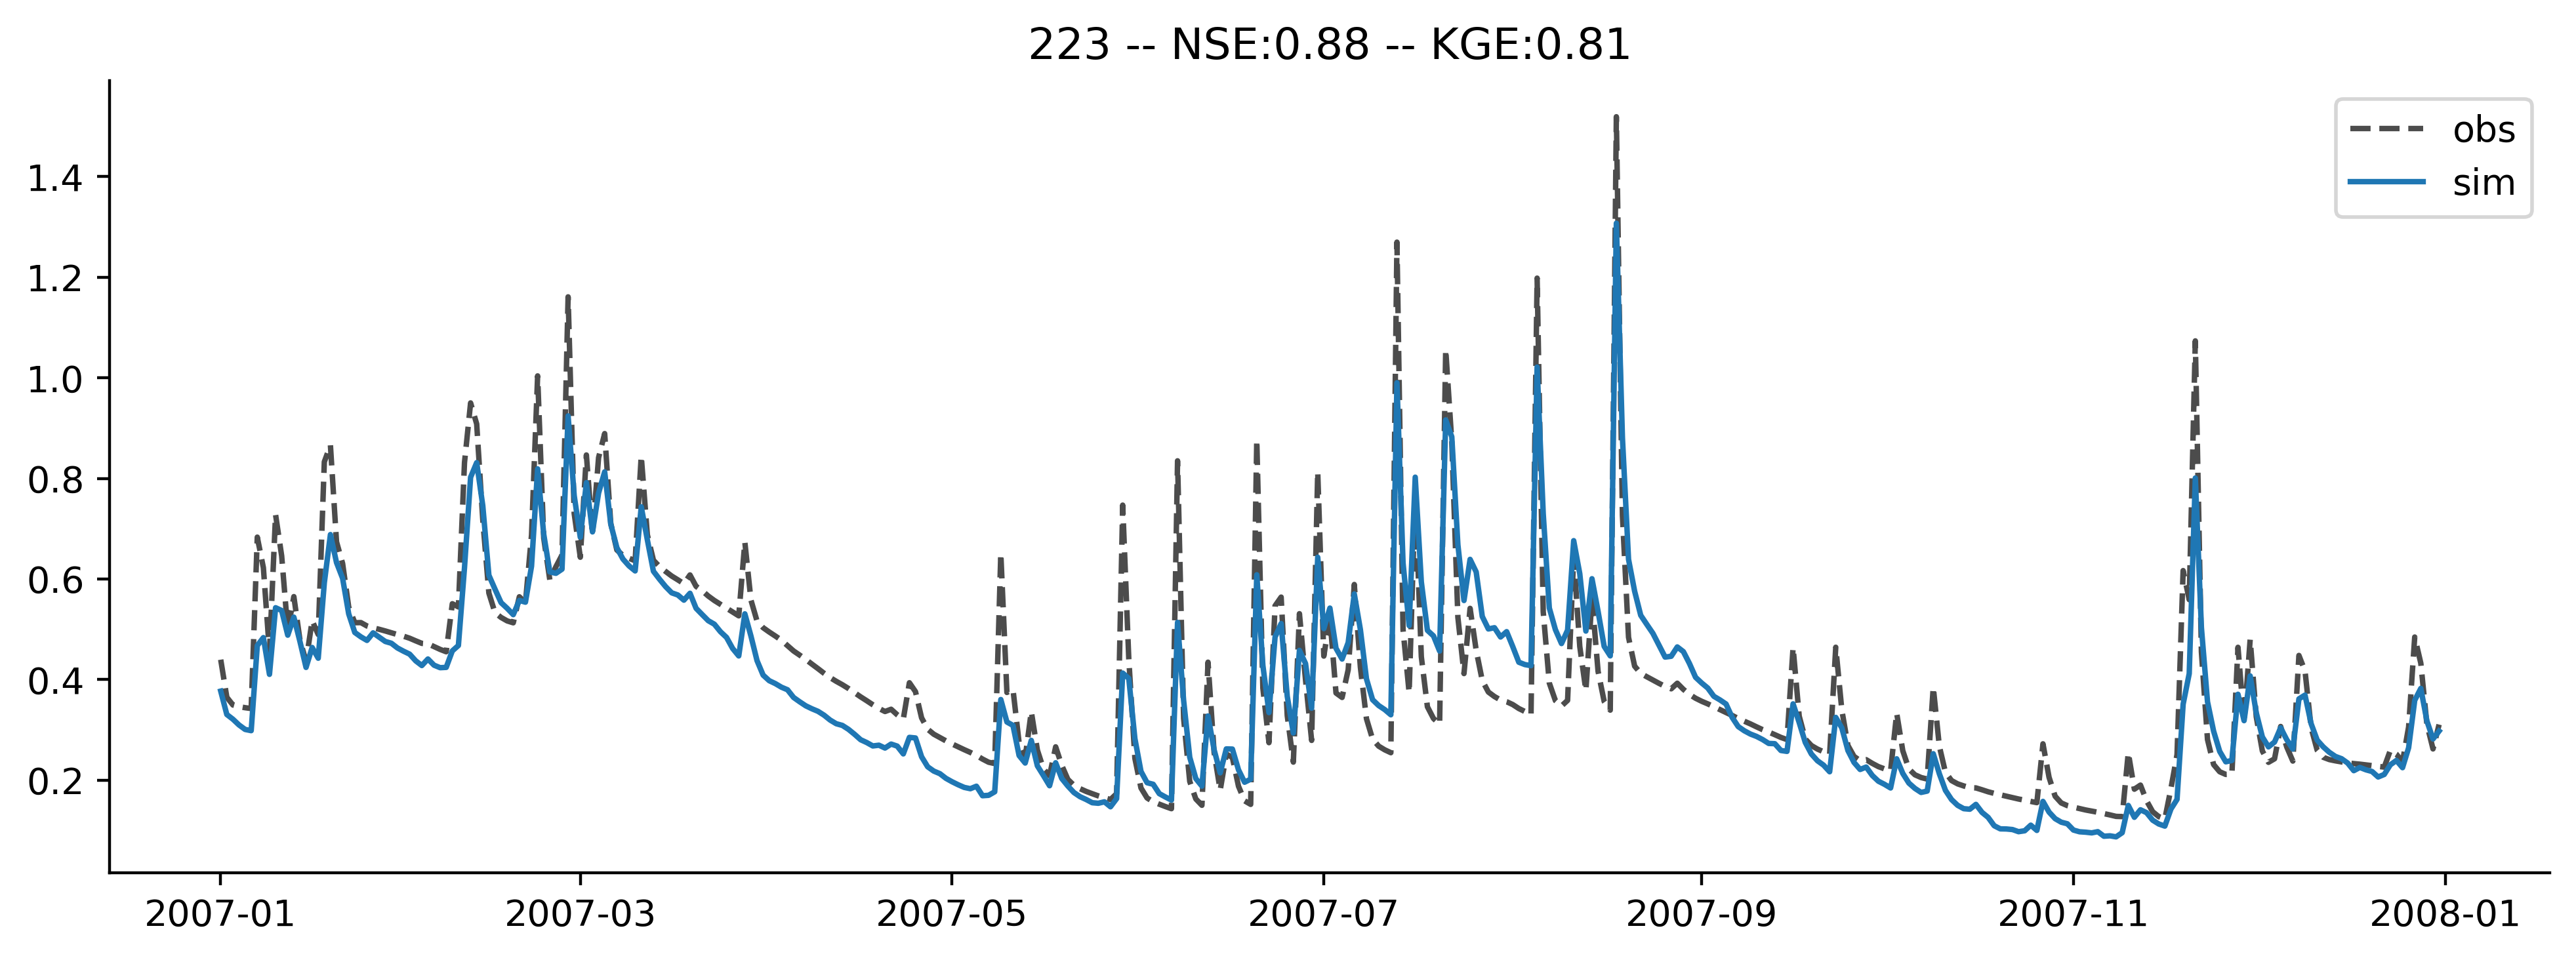

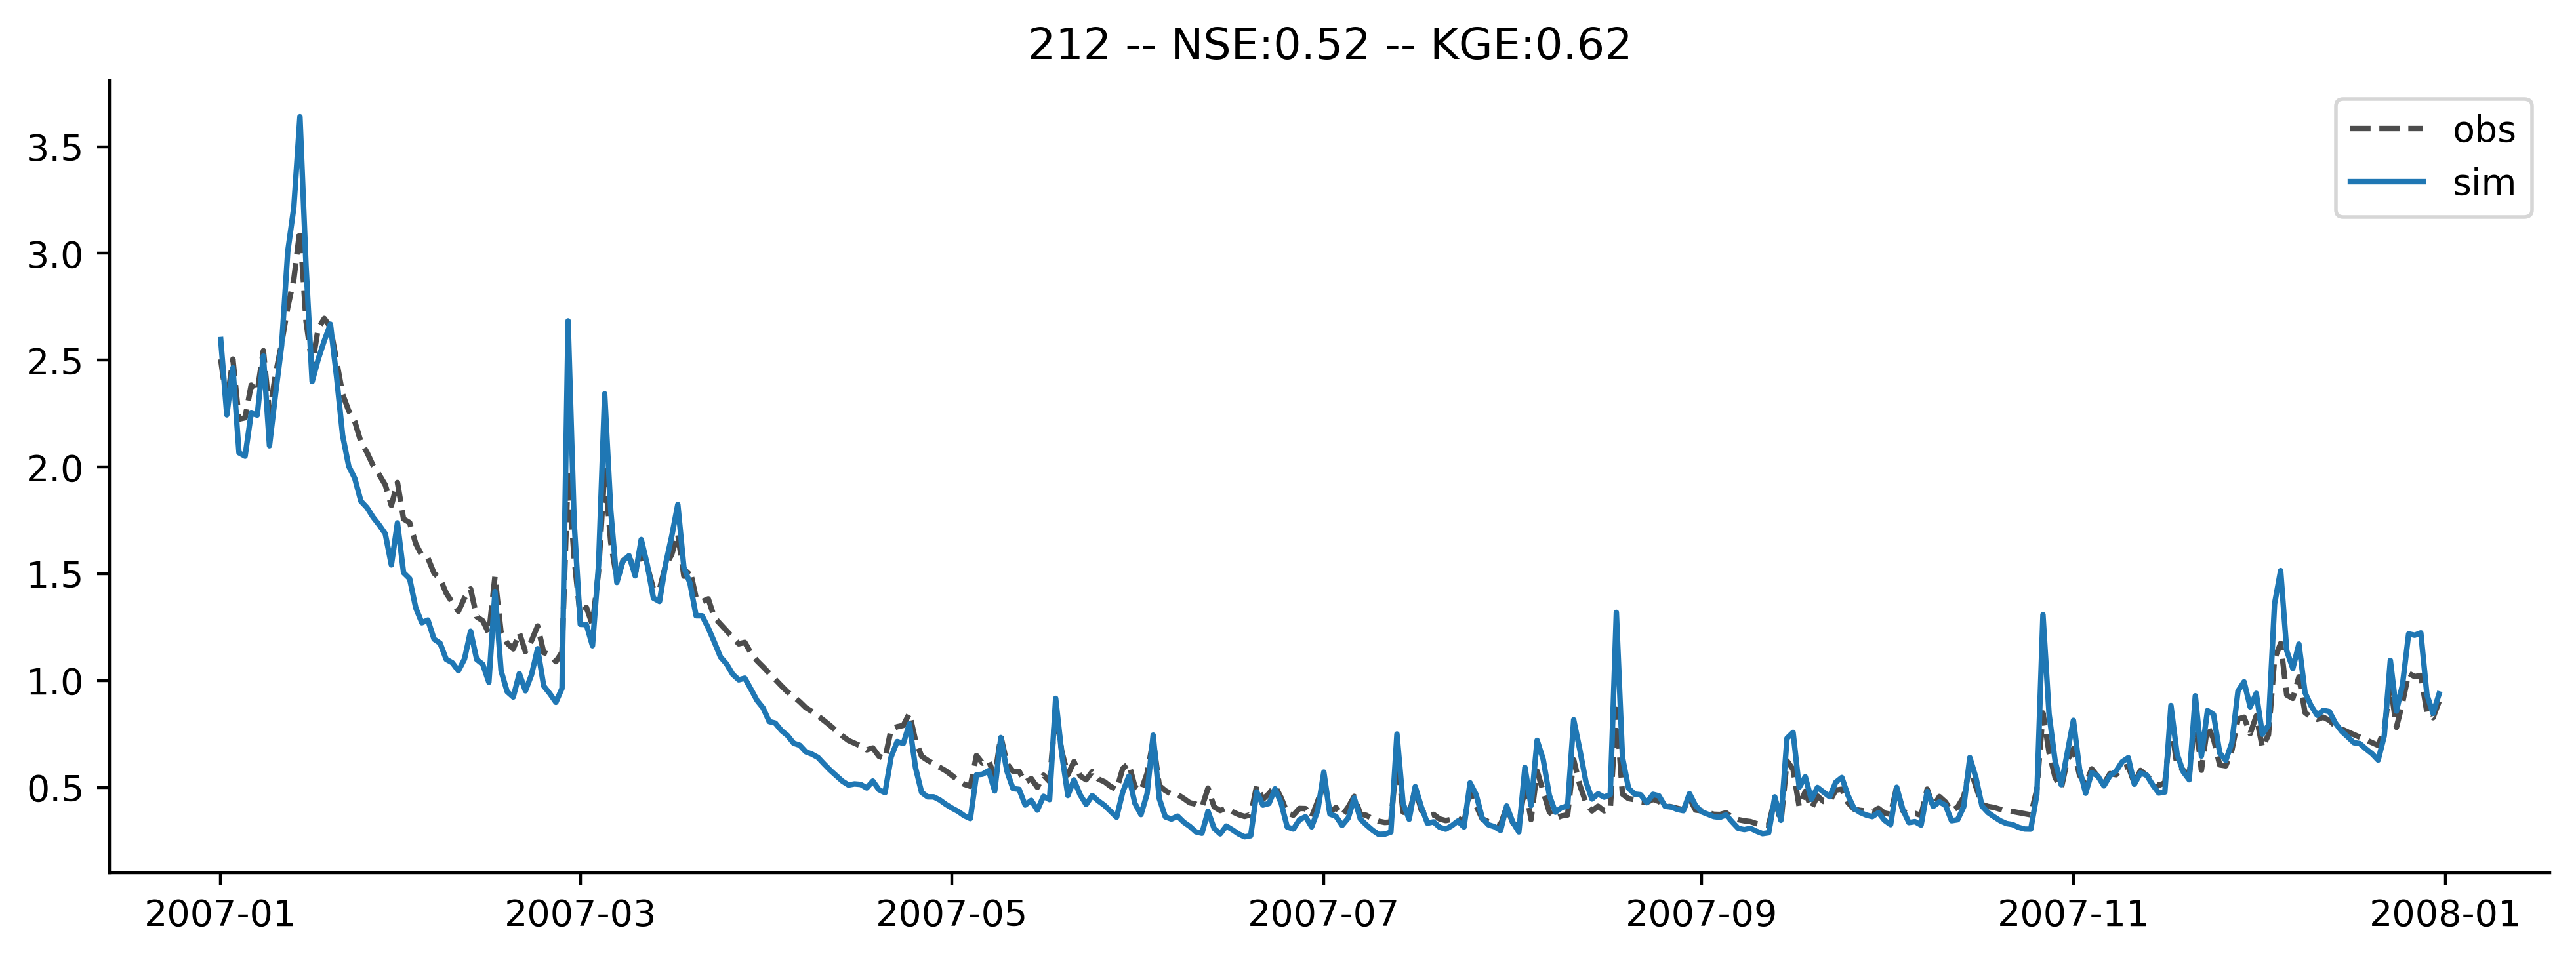

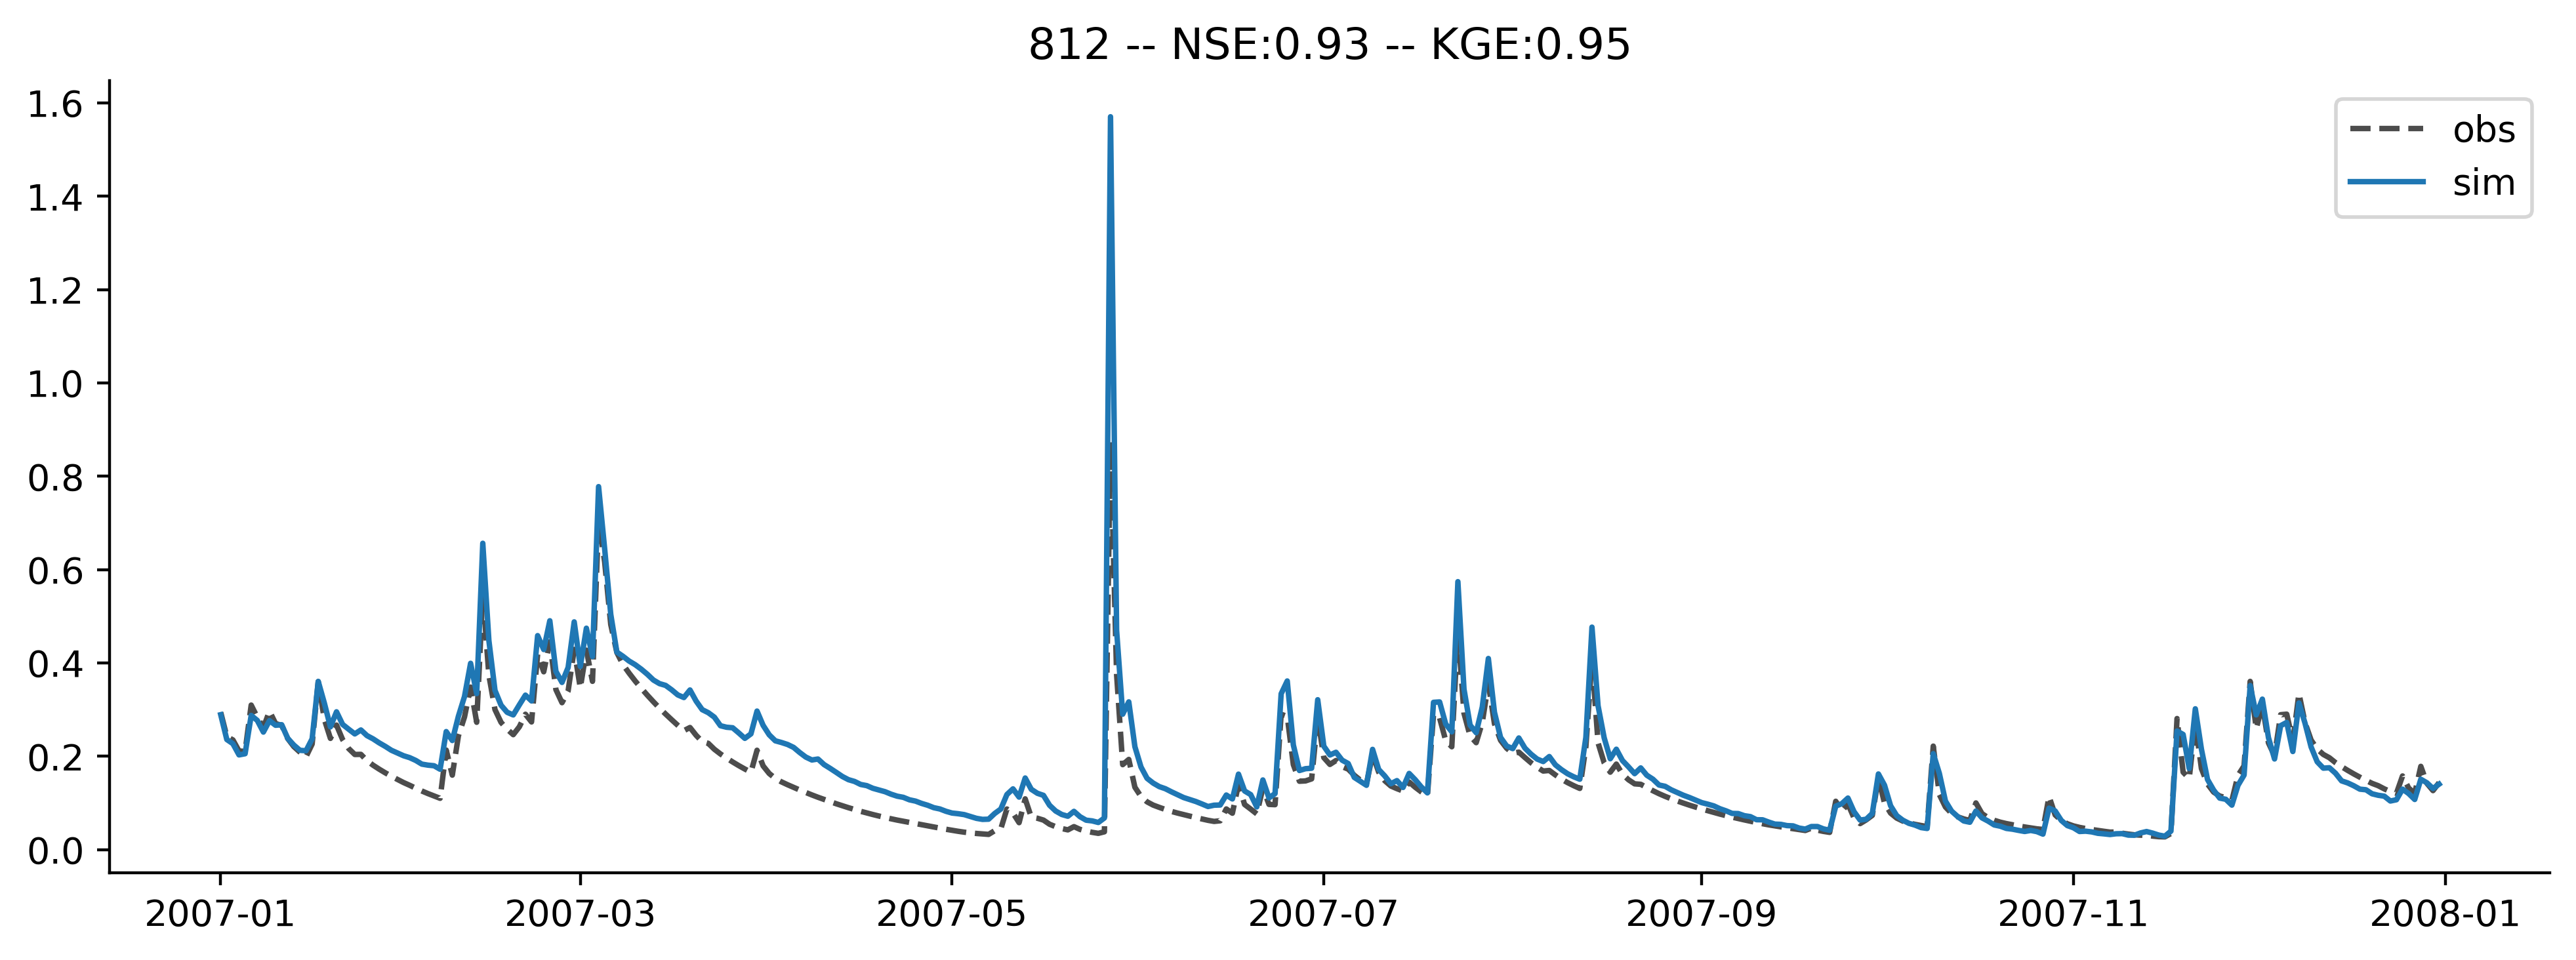

In [292]:
with plt.rc_context({'figure.dpi': 400}):

    N = 5
    pixels = np.random.choice(errors.station_id, N, replace=False)
    for pixel in pixels:
        f, ax = plt.subplots(figsize=(12, 4))
        #  preds.station_id.values   bottom_10_percent_sids
        p = preds.sel(time="2007", station_id=pixel)
        ax.plot(p.time, p[f"{cfg.target_variables[0]}_obs"], label="obs", color="k", ls="--", alpha=0.7)
        ax.plot(p.time, p[f"{cfg.target_variables[0]}_sim"], label="sim")

        ax.set_title(f"{pixel} -- NSE:{errors.sel(station_id=pixel).NSE.values:.2f} -- KGE:{errors.sel(station_id=pixel).KGE.values:.2f}")
        ax.legend()
        sns.despine()

<AxesSubplot:title={'center':'Hydrograph StationID: 495'}, ylabel='discharge_sim'>

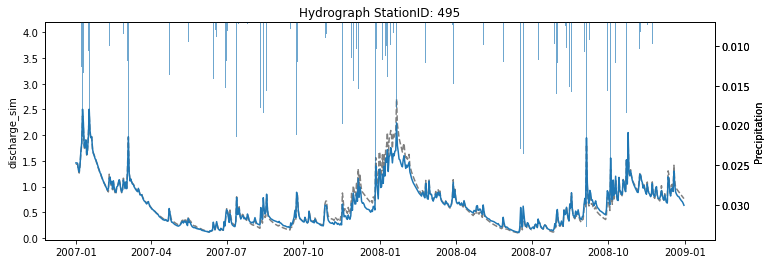

In [272]:
from scripts.plots import plot_hydrograph

PX = p.station_id
PX = 392 
PX = 495

data = dynamic.sel(station_id=PX, time=slice("2007", "2008"))
data = xr.merge([preds.sel(station_id=PX, time=slice("2007", "2008")), data])

ax = plot_hydrograph(
    data, discharge_var="discharge", precip_var="Precipitation", basin_dim="station_id", discharge_kwargs={"color": "k", "ls": "--", "alpha": 0.5, }
)
plot_hydrograph(
    data, discharge_var="discharge_sim", precip_var="Precipitation", basin_dim="station_id", discharge_kwargs={"color": "C0"}, ax=ax
)

In [145]:
camels_run_dir = data_dir / "runs/ensemble_NO_EVAP"
camels_lstm_preds = xr.open_dataset(camels_run_dir / "member_ds.nc")
camels_errors = xr.open_dataset(camels_run_dir/ "mean_errors.nc")

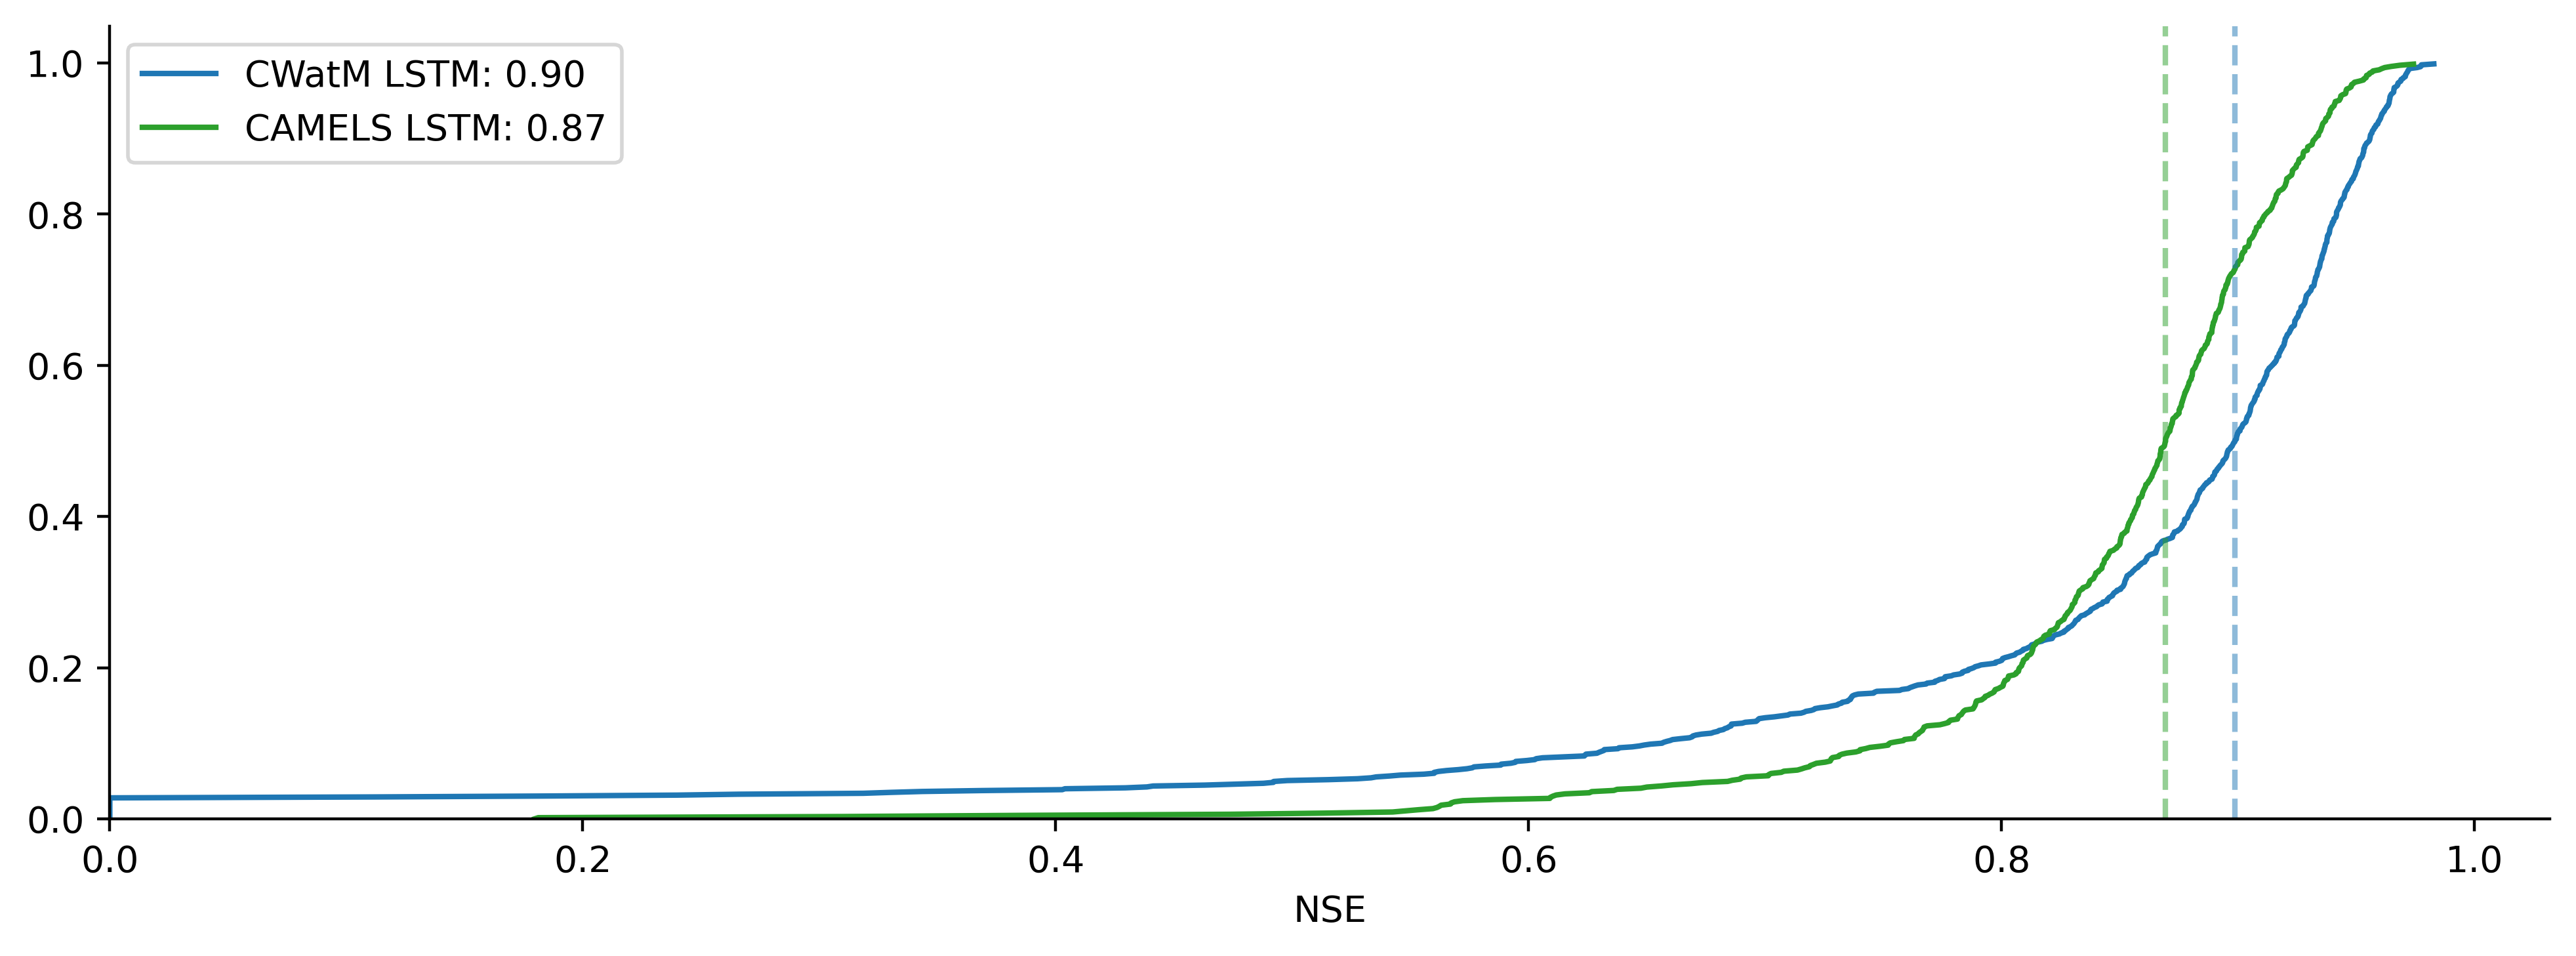

In [293]:
from typing import Any, Dict
import seaborn as sns
import matplotlib.pyplot as plt

# da = errors["NSE"].where(errors["NSE"] > 0)
# f, ax = plt.subplots(figsize=(12, 4))
# sns.kdeplot(da.values[np.isfinite(da)], cumulative=True, clip=(0, 1))
# sns.despine()

with plt.rc_context({'figure.dpi': 400}):

    f, ax = plt.subplots(figsize=(12, 4))

    def empirical_cdf(errors: np.ndarray, kwargs: Dict[str, Any] = {}):
        x = np.sort(errors)
        y = np.arange(len(x))/float(len(x))
        plt.plot(x, y, **kwargs)

    errors_plot = errors["NSE"].values[np.isfinite(errors["NSE"])]
    median = float(np.median(errors_plot))
    ref_median = float(np.median(camels_errors["NSE"]))
    errors_plot = errors_plot.clip(0, 1)

    empirical_cdf(errors_plot, kwargs={"label": f"CWatM LSTM: {median:.2f}"})
    empirical_cdf(camels_errors["NSE"], kwargs={"color": "C2",  "label": f"CAMELS LSTM: {ref_median:.2f}"})

    ax.axvline(median, ls="--", alpha=0.5, color="C0")
    ax.axvline(ref_median, ls="--", alpha=0.5, color="C2")

    ax.set_xlabel("NSE")
    ax.set_xlim(0, None)
    ax.set_ylim(0, None)
    ax.legend()
    sns.despine()

In [280]:
err_ = errors["NSE"].values[np.isfinite(errors["NSE"])]
f"{(err_ < 0).mean() * 100:.2f}% With NSE < 0"

'2.89% With NSE < 0'

#### is size a factor?

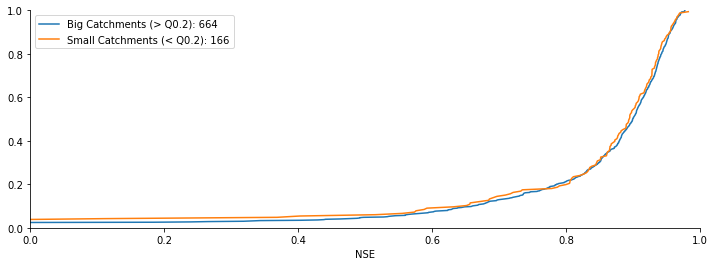

In [147]:
areas = static["area"].sel(station_id=np.isin(static.station_id, errors.station_id))
THRESH_Q = 0.2

big = areas.where(areas > areas.quantile(q=THRESH_Q), drop=True).station_id
small = areas.where(areas < areas.quantile(q=THRESH_Q), drop=True).station_id

f, ax = plt.subplots(figsize=(12, 4))
empirical_cdf(errors["NSE"].sel(station_id=big), kwargs={"color": "C0", "label": f"Big Catchments (> Q{THRESH_Q}): {big.size}"})
empirical_cdf(errors["NSE"].sel(station_id=small), kwargs={"color": "C1",  "label": f"Small Catchments (< Q{THRESH_Q}): {small.size}"})

ax.set_xlabel("NSE")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend()
sns.despine()

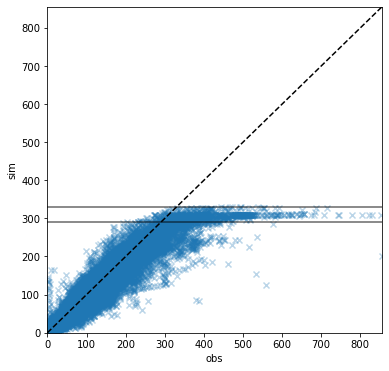

In [286]:
cam_ = camels_lstm_preds.mean(dim="member")

def scatter_plot(obs: np.ndarray, sim: np.ndarray, ax = None, scatter_kwargs: Dict = {"marker": "x", "color": "C0", "alpha": 0.3}):
    if ax is None:
        f, ax = plt.subplots(figsize=(6, 6))
    
    lim = (min([np.nanmin(obs), np.nanmin(sim)]), max([np.nanmax(obs), np.nanmax(sim)]))
    ax.scatter(obs, sim, **scatter_kwargs)
    ax.plot(lim, lim, ls="--", color="k")
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.set_xlabel("obs")
    ax.set_ylabel("sim")

    
epsilon = 1e-10
# x, y = np.log(cam_["obs"] + epsilon).values.flatten(), np.log(cam_["sim"] + epsilon).values.flatten()
# scatter_plot(obs=x, sim=y, scatter_kwargs={"marker": "x", "color": "C1", "alpha": 0.3})
# ax = plt.gca()

big_preds = preds.copy().sel(station_id=big)

log = False
if log:
    x, y = np.log(preds["discharge_obs"] + epsilon).values.flatten(), np.log(preds["discharge_sim"] + epsilon).values.flatten()
else:
    x, y = preds["discharge_obs"].values.flatten(), preds["discharge_sim"].values.flatten()

scatter_plot(obs=x, sim=y)

# x, y = cam_["obs"].values.flatten(), cam_["sim"].values.flatten()
# scatter_plot(obs=x, sim=y)

ax = plt.gca()

ref_lines = True
if ref_lines:
    ax.axhline(290, color="k", alpha=0.6)
    ax.axhline(330, color="k", alpha=0.6)

<xarray.DataArray 'station_id' (station_id: 9)>
array([242, 274, 328, 334, 385, 539, 611, 686, 741])
Coordinates:
  * station_id  (station_id) int64 242 274 328 334 385 539 611 686 741

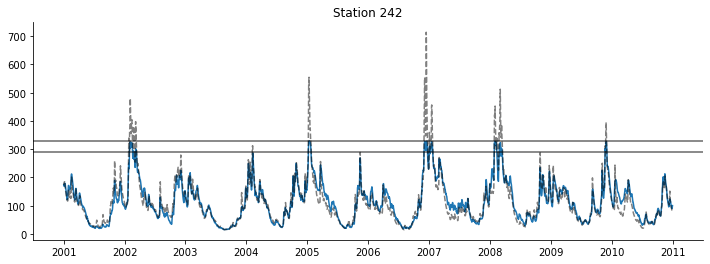

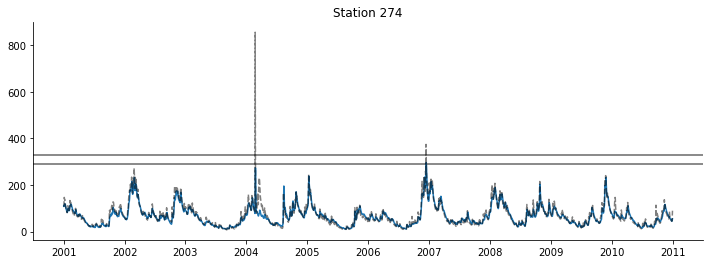

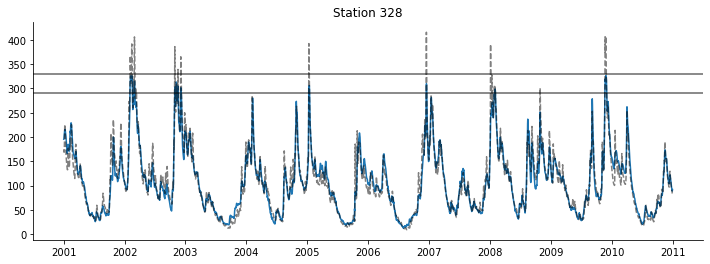

In [287]:
weird_stations = preds.where((preds["discharge_sim"] > 290) & (preds["discharge_sim"] < 330), drop=True).station_id

for px in weird_stations[:3]:
    p = preds.sel(station_id=px)
    f, ax = plt.subplots(figsize=(12, 4))
    ax.plot(p.time, p["discharge_sim"], color="C0")
    ax.plot(p.time, p["discharge_obs"], color="k", ls="--", alpha=0.5)
    ax.axhline(290, color="k", alpha=0.6)
    ax.axhline(330, color="k", alpha=0.6)
    ax.set_title(f"Station {int(px)}")
    sns.despine()

display(weird_stations)

# What about the worst stations?

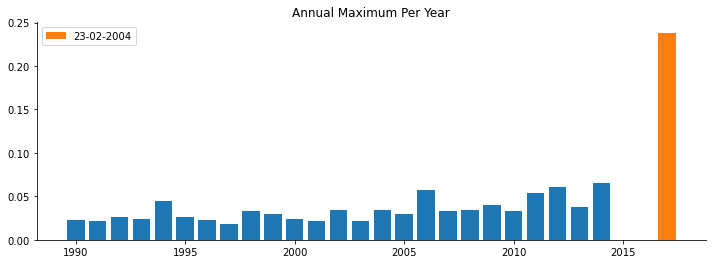

In [291]:
crazy_obs = dynamic.sel(station_id=sid, time="23-02-2004")["Precipitation"]
_data = dynamic.sel(station_id=[sid])["Precipitation"]
_data = xr.concat([_data.sel(time=slice("1990-01-01", "22-02-2004")), _data.sel(time=slice("24-02-2004", "2014-12-31"))], dim="time")
values = _data.groupby("time.year").max()

df = values.to_dataframe().reset_index()
# df = df.append(pd.DataFrame(({"station_id": sid, "year": "23-02-2004", "Precipitation": crazy_obs.values}), index=[25]))

f, ax = plt.subplots(figsize=(12, 4))
ax.bar(df["year"], df["Precipitation"])
ax.bar(2017, crazy_obs.values, label="23-02-2004")
ax.legend()
ax.set_title("Annual Maximum Per Year")
sns.despine()

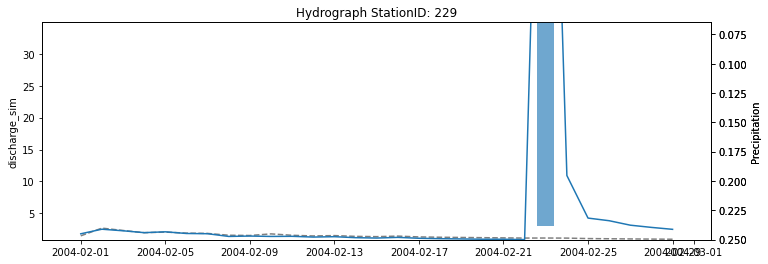

In [249]:
def plot_obs_preds_hydrographs(preds: xr.Dataset, dynamic: xr.Dataset, time: str, station_id: int):
    data = xr.merge([preds.sel(time=time, station_id=pixel), dynamic.sel(time=time, station_id=pixel)["Precipitation"]])
    ax = plot_hydrograph(
        data, discharge_var="discharge_obs", precip_var="Precipitation", basin_dim="station_id", discharge_kwargs={"color": "k", "ls": "--", "alpha": 0.5, }
    )
    plot_hydrograph(
        data, discharge_var="discharge_sim", precip_var="Precipitation", basin_dim="station_id", discharge_kwargs={"color": "C0"}, ax=ax
    )
    

plot_obs_preds_hydrographs(preds=preds, dynamic=dynamic, time="2004-02", station_id=sid)

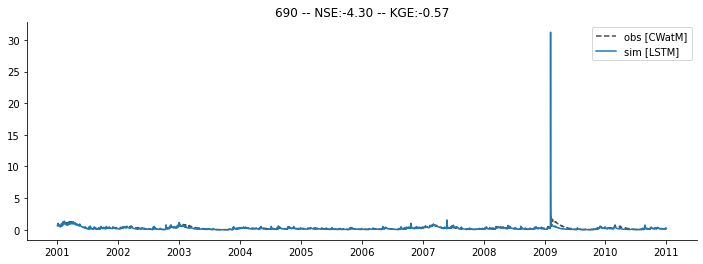

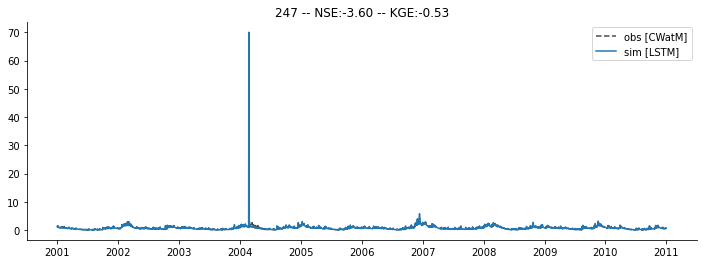

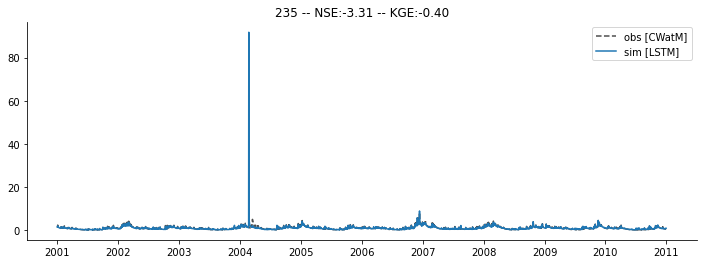

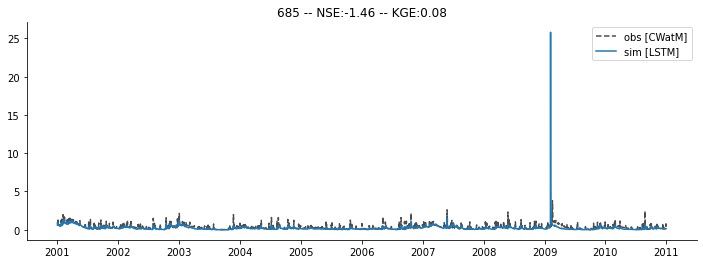

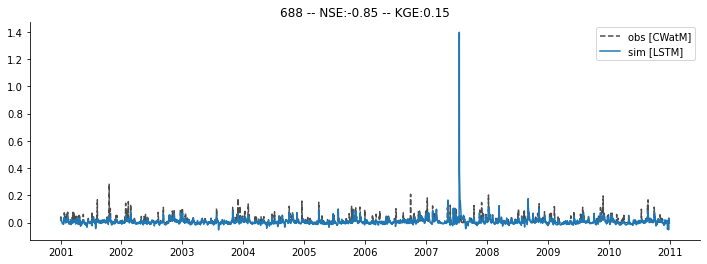

In [254]:
# bottom 10% of NSE scores
bottom_sids = errors.sel(station_id=errors["NSE"] < errors["NSE"].quantile(0.1)).sortby("NSE").station_id.values
pixels = np.random.choice(bottom_sids, 5, replace=False)
# bottom_sids = [215, 392, 733, 386, 686]
time = slice("2000", "2010")
# time = "2004"

twinx = False

for pixel in bottom_sids[10:15]:
    f, ax = plt.subplots(figsize=(12, 4))
    
    p = preds.sel(time=time, station_id=pixel)

    ax.plot(p["time"], p["discharge_obs"], label="obs [CWatM]", color="k", ls="--", alpha=0.7)
    
    if twinx:
        ax = ax.twinx()
    ax.plot(p["time"], p["discharge_sim"], label="sim [LSTM]")
    
    ax.set_title(f"{pixel} -- NSE:{errors.sel(station_id=int(pixel)).NSE.values:.2f} -- KGE:{errors.sel(station_id=int(pixel)).KGE.values:.2f}")
    ax.legend()
    sns.despine()

# Visualise Spatially

In [149]:
# # comparison
# orig_run_dir = Path("/datadrive/data/runs/azure_nh_runoff_30EPOCH_PIXEL_ALL_STATIC_0406_093025")
# orig_res_fp = get_test_filepath(orig_run_dir, epoch=30)
# orig_preds = get_all_station_ds(orig_res_fp)

# if "orig_errors" not in globals():
#     orig_errors = calculate_all_error_metrics(orig_preds, basin_coord="station_id")
# else:
#     print("Already run errors!")

In [150]:
import geopandas as gpd
from scripts.geospatial import initialise_gb_spatial_plot, load_latlon_points
from mpl_toolkits.axes_grid1 import make_axes_locatable

cwat_dir = data_dir / "CWATM"
points = gpd.read_file(cwat_dir / "gauge_points/gauge_points.shp").set_index("index")
errors["station_id"] = errors["station_id"].astype(int)

In [151]:
assert any(np.isin(errors["NSE"].to_dataframe().index, points.index))
gdf = gpd.GeoDataFrame(errors.to_dataframe().join(points))
gdf.head()

,Alpha-NSE,Beta-NSE,FHV,FLV,FMS,KGE,MSE,NSE,Peak-Timing,Pearson-r,RMSE,original_x,original_y,x,y,geometry
station_id,,,,,,,,,,,,,,,,
0,0.901720,-0.123024,3.165408,50.145097,-10.681937,0.842758,0.053962,0.814538,1.000000,0.910910,0.232298,3562500.0,4074500.0,420,52,POINT (-3.31052 59.12991)
1,0.911353,-0.014911,8.004317,51.362756,-22.637718,0.893384,0.360442,0.885808,0.111111,0.941784,0.600369,3562500.0,4057500.0,420,69,POINT (-3.25291 58.98012)
100,0.976427,-0.101858,1.893330,21.098718,-8.998412,0.908032,0.058283,0.900923,0.142857,0.954863,0.241418,3489500.0,3929500.0,347,197,POINT (-4.04280 57.72868)
101,0.934326,-0.109076,6.812059,20.194574,-22.719880,0.866835,0.043177,0.857936,0.600000,0.932650,0.207791,3491500.0,3929500.0,349,197,POINT (-4.00987 57.73219)
102,1.020971,-0.048339,5.882164,9.246063,-4.834947,0.956993,0.180922,0.963925,0.052632,0.983693,0.425349,3350500.0,3928500.0,208,198,POINT (-6.31298 57.45623)


<AxesSubplot:>

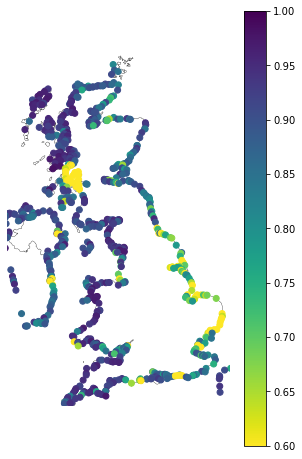

In [152]:
ax = initialise_gb_spatial_plot()
gdf.plot("NSE", ax=ax, vmin=0.6, vmax=1, cmap="viridis_r", legend=True)

In [209]:
from scripts.plots import plot_context
# from scripts.geospatial import plot_spatial_location

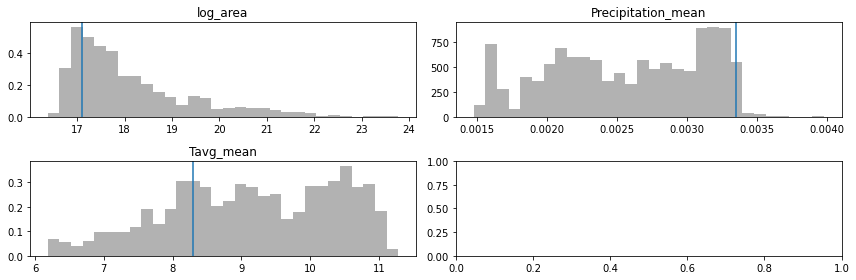

In [214]:
static["log_area"] = np.log(static["area"])

plot_context(static, sids=[15], variables=["log_area", "Precipitation_mean", "Tavg_mean"]);

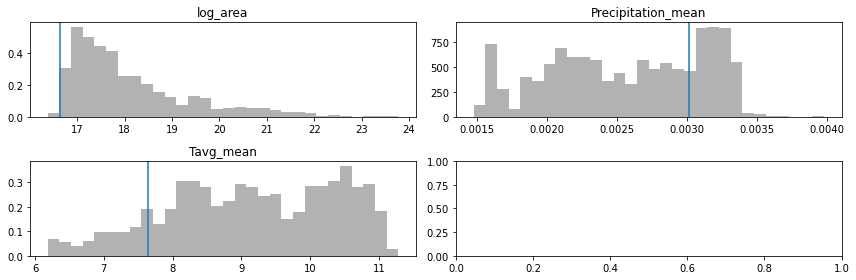

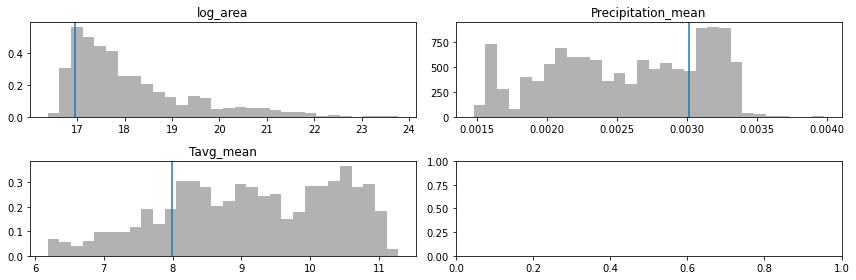

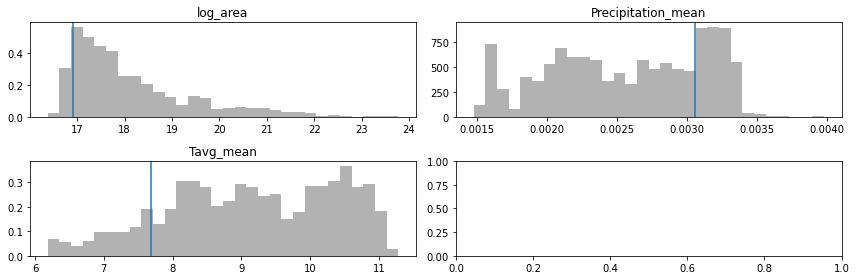

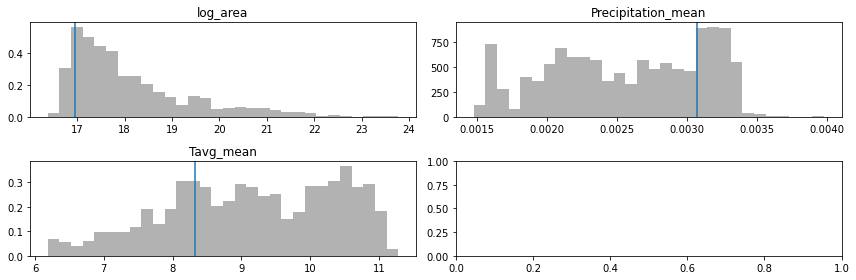

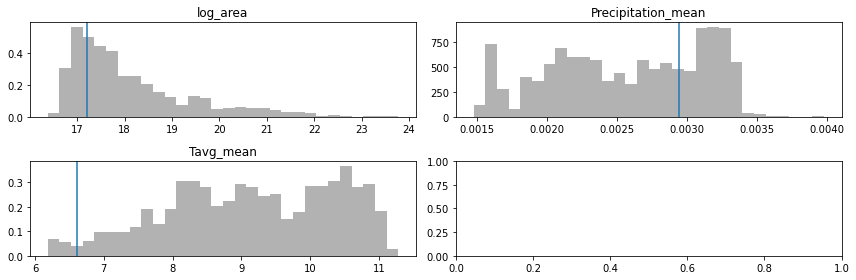

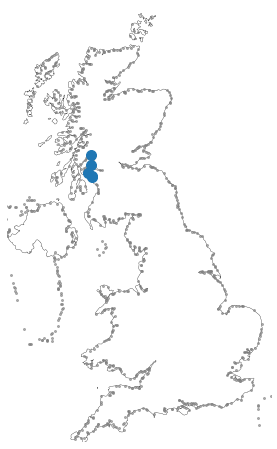

In [216]:
for sid in bottom_sids[:5]:
    plot_context(static, sids=[sid], variables=["log_area", "Precipitation_mean", "Tavg_mean"])
    
plot_spatial_location(bottom_sids[:5])

# Mutual information 
- which feature is most informative for errors?

In [156]:
from sklearn.feature_selection import mutual_info_regression

In [157]:
def describe_xr_by_spatial_dim(da: xr.DataArray, spatial_dim: str = "station_id") -> xr.Dataset:
    assert da.name is not None
    summary_df = da.to_dataframe().reset_index(spatial_dim).groupby(spatial_dim).describe()
    summary_df.columns = [f"{da.name}_{c}" for c in summary_df.columns.get_level_values(1)]
    return summary_df.to_xarray()

# expand static data
q_summ = describe_xr_by_spatial_dim(dynamic["discharge"])
static = xr.merge([static, q_summ])

In [158]:
from collections import defaultdict

def get_non_nan_mask(da1: np.ndarray, da2: np.ndarray):
    assert da1.shape == da2.shape
    return ~(np.isnan(da1) | np.isnan(da2))


Y = errors["NSE"]

output = defaultdict(list)
for var in static.data_vars:
    X = static[var].sel(station_id=Y.station_id)
    mask = get_non_nan_mask(Y, X)
    x, y = X[mask].values.reshape(-1, 1), Y[mask].values
    mi_score = mutual_info_regression(x, y)[0]
    
    output["variable"].append(var)
    output["mi_score"].append(mi_score)
    
df = pd.DataFrame(output)
df.head()

,variable,mi_score
0,Precipitation_mean,0.345553
1,Tavg_mean,0.086886
2,area,0.038572
3,discharge_count,0.000000
4,discharge_mean,0.105091


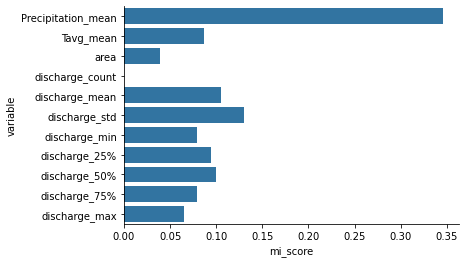

In [159]:
sns.barplot(x="mi_score", y="variable", data=df, color="C0")
sns.despine()

## What variables are most linked to errors?

Text(0, 0.5, 'nse')

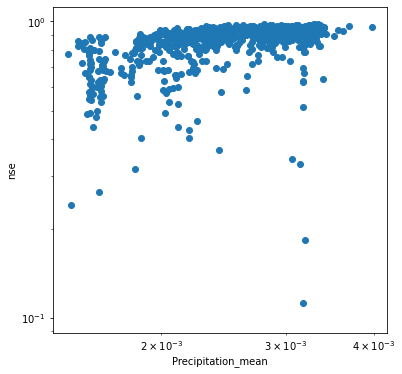

In [160]:
var = "Precipitation_mean"

# get the x var
X = static[var].sel(station_id=Y.station_id)
mask = get_non_nan_mask(Y, X)
x, y = X[mask].values.reshape(-1, 1), Y[mask].values

# plot x y scatter
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x, y)
plt.yscale("log")
plt.xscale("log")

ax.set_xlabel(var)
ax.set_ylabel("nse")

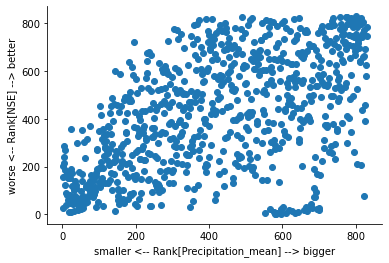

In [161]:
# plot the ranks
var_df = pd.DataFrame({var: x.flatten(), "nse": y})
rank = var_df.rank(ascending=True)
rank.columns = [f"rank_{c}" for c in rank.columns]
rank = rank.join(var_df)

f, ax = plt.subplots(figsize=(6, 4))
ax.scatter(rank[f"rank_{var}"], rank["rank_nse"])
ax.set_xlabel(f"smaller <-- Rank[{var}] --> bigger")
ax.set_ylabel(f"worse <-- Rank[NSE] --> better")
sns.despine()

In [162]:
from scipy import stats


def _assign_n_bins_to_df(df: pd.DataFrame, var: str, n_bins: int = None, edges: Optional[List[float]] = None):
    if edges is None:
        assert n_bins is not None, "Must provide int to n_bins argument"
        count, edges = np.histogram(df[var], density=False, bins=n_bins)   
        # N = area_df[var].size
        # edges = stats.mstats.mquantiles(df[var], [0, 2./N, 4./N, 1])

    df[f"{var}_bins"] = pd.cut(df[var], bins=edges)
    df[f"{var}_bin_int"] = df[f"{var}_bins"].cat.codes
    return df


var_df = _assign_n_bins_to_df(var_df, var=var, n_bins=5)
# edges = [-40, -20, 0, 0.2, 0.4, 1]
var_df = _assign_n_bins_to_df(var_df, var="nse", edges=None, n_bins=5)
var_df.head()

,Precipitation_mean,nse,Precipitation_mean_bins,Precipitation_mean_bin_int,nse_bins,nse_bin_int
0,0.002819,0.814538,"(0.0024800000246614218, 0.0029800001066178083]",2,"(-3.841, 0.983]",4
1,0.002824,0.885808,"(0.0024800000246614218, 0.0029800001066178083]",2,"(-3.841, 0.983]",4
2,0.002106,0.900923,"(0.001979999942705035, 0.0024800000246614218]",1,"(-3.841, 0.983]",4
3,0.001903,0.857936,"(0.0014799999771639705, 0.001979999942705035]",0,"(-3.841, 0.983]",4
4,0.003228,0.963925,"(0.0029800001066178083, 0.0034799999557435513]",3,"(-3.841, 0.983]",4


# In what conditions do we find the best performing stations?

In [163]:
variables=["log_area", "Precipitation_mean", "Tavg_mean", "log_discharge_mean"]
len(variables) // 2

n = 9


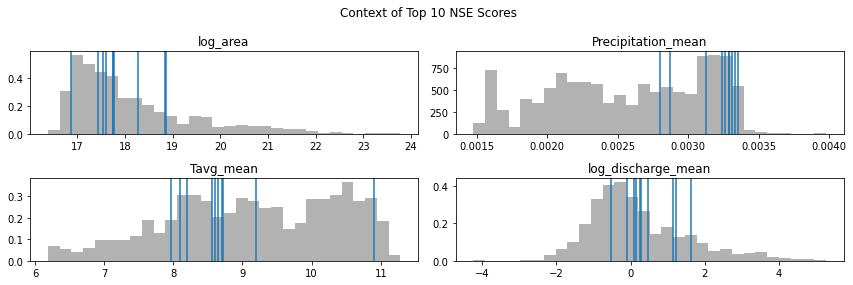

In [164]:
def plot_multiple_sids_in_context(sids: int, variables: List[str]):
    n = len(variables)
    nrows = n // 2 + (n % 2)
    f, axs = plt.subplots(nrows, 2, figsize=(12, 4), tight_layout=True)

    for ix, var_ in enumerate(variables):
        ax = axs[np.unravel_index(ix, (nrows, 2))]
        ax.hist(static[var_], color="grey", alpha=0.6, bins=30, density=True)
        ax.set_title(f"{var_}")
        
        for sid in sids:
            ax.axvline(static[var_].sel(station_id=sid))
            rank = float(static[var_].to_dataframe().rank().loc[sid].values)
        

static["log_discharge_mean"] = np.log(static["discharge_mean"])
static["log_area"] = np.log(static["area"])

best_sids = errors.sortby("NSE", ascending=True)["NSE"][-10:].station_id.values
plot_multiple_sids_in_context(best_sids, variables=["log_area", "Precipitation_mean", "Tavg_mean", "log_discharge_mean"])
plt.gcf().suptitle("Context of Top 10 NSE Scores");

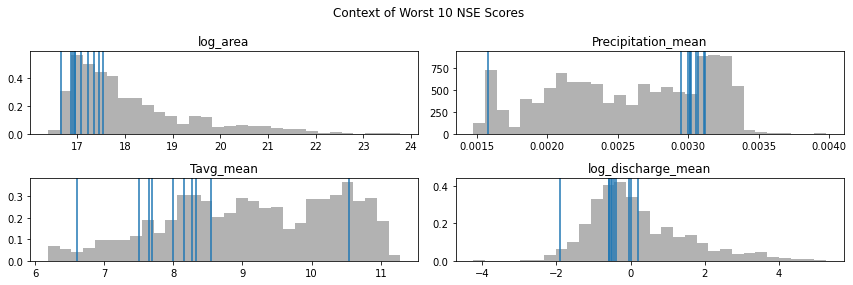

In [165]:
worst_sids = errors.sortby("NSE", ascending=False)["NSE"][-10:].station_id.values
plot_multiple_sids_in_context(worst_sids, variables=["log_area", "Precipitation_mean", "Tavg_mean", "log_discharge_mean"])
plt.gcf().suptitle("Context of Worst 10 NSE Scores");